In [4]:
import pandas as pd

# some lines have too many fields (?), so skip bad lines
imgatt = pd.read_csv("dataset/CUB_200_2011/CUB_200_2011/attributes/image_attribute_labels.txt",
                    sep='\s+', header=None, error_bad_lines=False, warn_bad_lines=False,
                    usecols=[0,1,2], names=['imgid','attid','present'])

# description from dataset README:
#
# The set of attributes labels as perceived by MTurkers for each image
# is contained in the file attributes/image_attributes_labels.txt, with
# each line corresponding to one image/attribute/worker triplet:
#
# <image_id> <attribute_id> <is_present> <certainty_id> <time>
# 
# where <image_id>, <attribute_id>, <certainty_id> correspond to the IDs
# in images.txt, attributes/attributes.txt, and attributes/certainties.txt
# respectively. <is_present> is 0 or 1 (i denotes that the attributes is
# present). <time> denotes the time spent by the MTurker in seconds.

In [5]:
imgatt.head()

,imgid,attid,present
0,1,1,0
1,1,2,0
2,1,3,0
3,1,4,0
4,1,5,1


In [7]:
imgatt.shape

(3677856, 3)

In [9]:
# need to reorganize imgatt to have one row per imgid, and 312 columns (one column per attribute),
# with 1/0 in each cell  representing  if that imgatt has that attribute or not

imgatt2 = imgatt.pivot(index='imgid', columns='attid', values='present')

In [10]:
imgatt2.head()

attid,1,2,3,4,5,6,7,8,9,10,...,303,304,305,306,307,308,309,310,311,312
imgid,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [11]:
imgatt2.shape

(11788, 312)

In [12]:
# now we need to load the image true classes

imglabels = pd.read_csv("dataset/CUB_200_2011/CUB_200_2011/image_class_labels.txt",
                       sep=' ', header=None, names=['imgid', 'label'])

imglabels = imglabels.set_index('imgid')

# description from the dataset README:
#
# The ground truth class labels (birds species labels) for each image are contained
# in the file image_class_labels.txt, with each line corresponding to one image:
#
# <image_id> <class_id>
# 
# where <image_id> and <class_id> correspond to the IDs in image.txt and classes.txt,
# respectively.txt

In [13]:
imglabels.head()

,label
imgid,
1,1
2,1
3,1
4,1
5,1


In [14]:
imglabels.shape

(11788, 1)

In [15]:
# now we need to attach the labels to the attribute data set
# and shuffle; then we'll separate a test set from a training set

df = imgatt2.join(imglabels)
df = df.sample(frac=1)

In [16]:
df_att = df.iloc[:, :312]
df_label = df.iloc[:, 312:]

In [17]:
df_att.head()

,1,2,3,4,5,6,7,8,9,10,...,303,304,305,306,307,308,309,310,311,312
imgid,,,,,,,,,,,,,,,,,,,,,
3040,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
9349,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
42,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,1,0,0,0
10118,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
6348,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,1


In [18]:
df_label.head()

,label
imgid,
3040,53
9349,159
42,1
10118,172
6348,109


In [19]:
df_train_att = df_att[:8000]
df_train_label = df_label[:8000]
df_test_att = df_att[8000:]
df_test_label = df_label[8000:]

df_train_label = df_train_label['label']
df_test_label = df_test_label['label']

In [20]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_features=50, random_state=0, n_estimators=100)

In [21]:
clf.fit(df_train_att, df_train_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=50, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [22]:
print(clf.predict(df_test_att.head()))

[130  51 171 112 156]


In [23]:
clf.score(df_test_att, df_test_label)

0.4324181626187962

In [26]:
from sklearn.metrics import confusion_matrix
pred_labels = clf.predict(df_test_att)
cm = confusion_matrix(df_test_label, pred_labels)

In [27]:
cm

array([[ 2,  0,  0, ...,  0,  0,  0],
       [ 0, 13,  0, ...,  0,  0,  0],
       [ 1,  1,  8, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  4,  0,  0],
       [ 1,  0,  0, ...,  0,  7,  0],
       [ 0,  0,  0, ...,  0,  0, 14]])

In [ ]:
# from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
        
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks,classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    # for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    #     plt.text(j, i, format(cm[i,j], fmt)),
    #              horizontalalignment="center"
    #              color="white" if cm[i,j] > thresh else "black"
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [31]:
birds = pd.read_csv("dataset/CUB_200_2011/CUB_200_2011/classes.txt",
                  sep='\s+', header=None, usecols=[1], names=['birdname'])
birds = birds['birdname']
birds

0              001.Black_footed_Albatross
1                    002.Laysan_Albatross
2                     003.Sooty_Albatross
3                   004.Groove_billed_Ani
4                      005.Crested_Auklet
5                        006.Least_Auklet
6                     007.Parakeet_Auklet
7                   008.Rhinoceros_Auklet
8                    009.Brewer_Blackbird
9                010.Red_winged_Blackbird
10                    011.Rusty_Blackbird
11            012.Yellow_headed_Blackbird
12                           013.Bobolink
13                     014.Indigo_Bunting
14                     015.Lazuli_Bunting
15                    016.Painted_Bunting
16                           017.Cardinal
17                    018.Spotted_Catbird
18                       019.Gray_Catbird
19               020.Yellow_breasted_Chat
20                     021.Eastern_Towhee
21                   022.Chuck_will_Widow
22                   023.Brandt_Cormorant
23                024.Red_faced_Co

In [ ]:
import numpy as np
np.set_printoptions(precision=2)
plt.figure(figsize=(60,60), dpi=300)
plot_confusion_matrix(cm, classes=birds, normalize=True)
plt.show()

In [38]:
from sklearn import tree
clftree = tree.DecisionTreeClassifier()
clftree.fit(df_train_att, df_train_label)
clftree.score(df_test_att, df_test_label)

0.2550158394931362

In [39]:
from sklearn import svm
clfsvm = svm.SVC()
clfsvm.fit(df_train_att, df_train_label)
clfsvm.score(df_test_att, df_test_label)

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.26003167898627244

In [41]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, df_train_att, df_train_label, cv=5)
# show average score and +/- two standard deviations away (covering 95% of scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()*2))

Accuracy: 0.44 (+/- 0.03)


In [42]:
scorestree = cross_val_score(clftree, df_train_att, df_train_label, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scorestree.mean(), scorestree.std()*2))

Accuracy: 0.26 (+/- 0.01)


In [43]:
scoressvm = cross_val_score(clftree, df_train_att, df_train_label, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scoressvm.mean(), scoressvm.std()*2))

Accuracy: 0.26 (+/- 0.02)


In [46]:
max_features_opts = range(5, 50, 5)
n_estimators_opts = range(10, 200, 20)
rf_params = np.empty((len(max_features_opts)*len(n_estimators_opts),4),float)
i = 0
for max_features in max_features_opts:
    for n_estimators in n_estimators_opts:
        clf = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators)
        scores = cross_val_score(clf, df_train_att, df_train_label, cv=5)
        rf_params[i,0] = max_features
        rf_params[i,1] = n_estimators
        rf_params[i,2] = scores.mean()
        rf_params[i,3] = scores.std()*2
        i += 1
        print("Max features %d, num estimators %d, accuracy: %0.2f (+/- %0.2f)" % \
             (max_features, n_estimators, scores.mean(), scores.std()*2))

Max features 5, num estimators 10, accuracy: 0.27 (+/- 0.01)
Max features 5, num estimators 30, accuracy: 0.36 (+/- 0.02)
Max features 5, num estimators 50, accuracy: 0.40 (+/- 0.02)
Max features 5, num estimators 70, accuracy: 0.41 (+/- 0.01)
Max features 5, num estimators 90, accuracy: 0.43 (+/- 0.01)
Max features 5, num estimators 110, accuracy: 0.44 (+/- 0.02)
Max features 5, num estimators 130, accuracy: 0.44 (+/- 0.01)
Max features 5, num estimators 150, accuracy: 0.44 (+/- 0.01)
Max features 5, num estimators 170, accuracy: 0.44 (+/- 0.01)
Max features 5, num estimators 190, accuracy: 0.45 (+/- 0.00)
Max features 10, num estimators 10, accuracy: 0.29 (+/- 0.03)
Max features 10, num estimators 30, accuracy: 0.39 (+/- 0.02)
Max features 10, num estimators 50, accuracy: 0.41 (+/- 0.01)
Max features 10, num estimators 70, accuracy: 0.43 (+/- 0.01)
Max features 10, num estimators 90, accuracy: 0.44 (+/- 0.01)
Max features 10, num estimators 110, accuracy: 0.44 (+/- 0.02)
Max features

KeyboardInterrupt: 

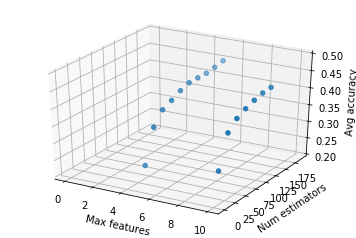

In [48]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
fig = plt.figure()
fig.clf()
ax = fig.gca(projection='3d')
x = rf_params[:,0]
y = rf_params[:,1]
z = rf_params[:,2]
ax.scatter(x, y, z)
ax.set_zlim(0.2, 0.5)
ax.set_xlabel("Max features")
ax.set_ylabel("Num estimators")
ax.set_zlabel("Avg accuracy")
plt.show()